# Overfitting

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt
import time

import utils
import plot
import metrics

from svgd import SVGD, get_bandwidth

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
from jax.scipy.stats import multivariate_normal
mean = np.array([-5,-5])
cov = np.array([[6,1], [1, 10]])
var = np.diagonal(cov)
assert utils.is_pd(cov)
logp22 = lambda x: multivariate_normal.logpdf(x, mean, cov)

In [3]:
n = 100
d = 2
stepsize = 0.01
L = int(3 / stepsize)

svgd_adaptive22 = SVGD(logp=logp22, n_iter_max=L, adaptive_kernel=True, get_bandwidth=get_bandwidth, particle_shape=(n, d))

In [4]:
svgd_adaptive22.newkey()
xout22, log22 = svgd_adaptive22.svgd(svgd_adaptive22.rkey, stepsize, bandwidth=0, n_iter=L)
xout22.block_until_ready()
print()

JIT COMPILING svgd...
...done compiling svgd after 0.5275871753692627 seconds.



8 4


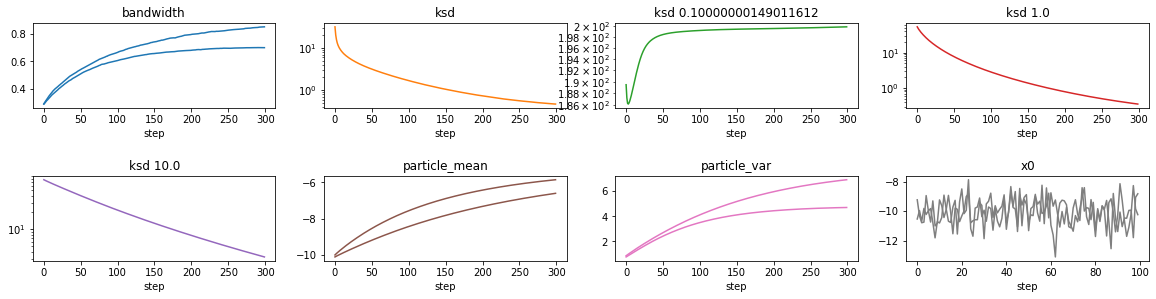

In [5]:
plot.svgd_log(log22)

var - true = [-1.2951307 -3.0778065]
mean - true = [-0.8451543 -1.5930133]


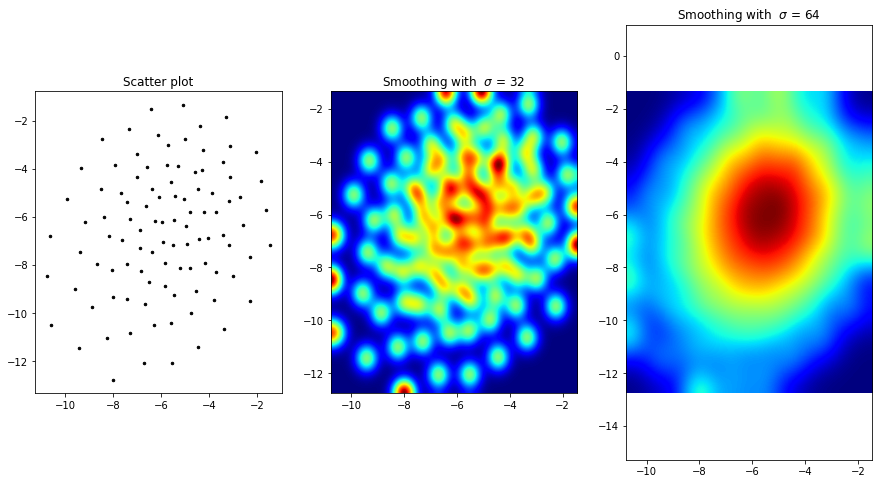

In [6]:
print("var - true =", np.var(xout22, axis=0) - var)
print("mean - true =", np.mean(xout22, axis=0) - mean)

plot.bivariate_hist(xout22)

Comparison histogram:

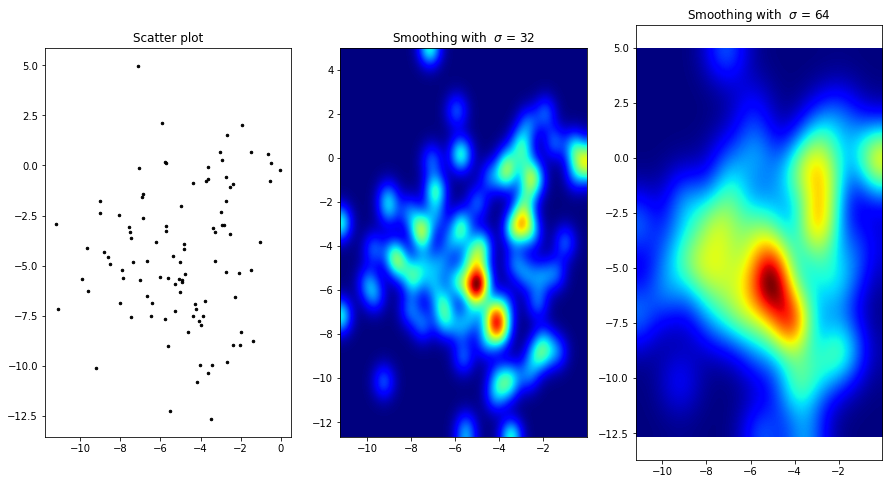

var - true = [0.24239874 1.8112535 ]
mean - true= [0.01119852 0.520844  ]


In [18]:
rkey = random.PRNGKey(0)
xtest = random.multivariate_normal(rkey, mean, cov, shape=(100,))

plot.bivariate_hist(xtest)
print("var - true =", np.var(xtest, axis=0) - var)
print("mean - true=", np.mean(xtest, axis=0) - mean)

In [8]:
T = xout22 - log22["x0"]

In [9]:
svgd_adaptive22.newkey()
x0 = svgd_adaptive22.initialize(svgd_adaptive22.rkey)
xout = x0 + T
for _ in range(300):
    svgd_adaptive22.newkey()
    x0 = svgd_adaptive22.initialize(svgd_adaptive22.rkey)
    xout = np.concatenate([xout, x0 + T], axis=0)

print(xout.shape)

(30100, 2)


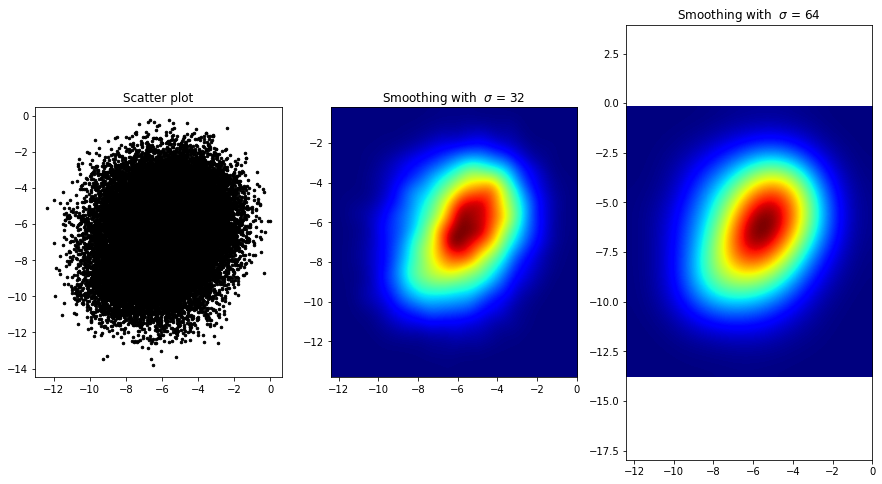

here's the 'losses' for the samples constructed through x0 + T:
var - true = [-2.5994883 -5.5853295]
mean - true= [-0.84782076 -1.4872174 ]

For comparison, here's the same values for the svgd sample:
var - true = [-1.2951307 -3.0778065]
mean - true = [-0.8451543 -1.5930133]


In [10]:
plot.bivariate_hist(xout)

print("here's the 'losses' for the samples constructed through x0 + T:")
print("var - true =", np.var(xout, axis=0) - var)
print("mean - true=", np.mean(xout, axis=0) - mean)

print()
print("For comparison, here's the same values for the svgd sample:")

print("var - true =", np.var(xout22, axis=0) - var)
print("mean - true =", np.mean(xout22, axis=0) - mean)

# Conclusion
The sampled particles fit the target distribution well (around $0.2$ difference in mean and variance). But when we apply the same transformation to other samples from the same initial distribution $q_0$, the fit to the target distribution is far worse (up to $1.4$ difference). In a sense, the transformation obtained by SVGD overfits the particles used to generate the transformation.

# Actually
On second thought, this is nonsense. Of course the first method approximates the target distribution better, and it's not overfitting. The transformation $T$ isn't simply additive, so we're not applying the right trafo in the second case. It only approximately fits the distribution because the structure is so simple in this example.



# Two track. Estimate transformation

In [21]:
n = 100
d = 2
stepsize = 0.01
L = int(10 / stepsize)

svgd_adaptive22 = SVGD(logp=logp22, n_iter_max=L, adaptive_kernel=True, get_bandwidth=get_bandwidth, particle_shape=(n, d))

In [22]:
svgd_adaptive22.newkey()
xout, xest, log = svgd_adaptive22.svgd_twotrack(svgd_adaptive22.rkey, stepsize, bandwidth=0, n_iter=L)
xout.block_until_ready()
print()

JIT COMPILING svgd_twotrack...
...done compiling svgd_twotrack after 0.12643003463745117 seconds.



8 4


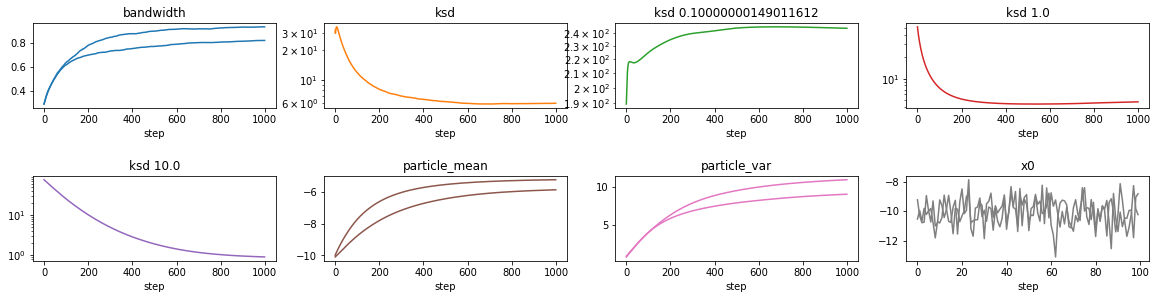

In [23]:
plot.svgd_log(log)

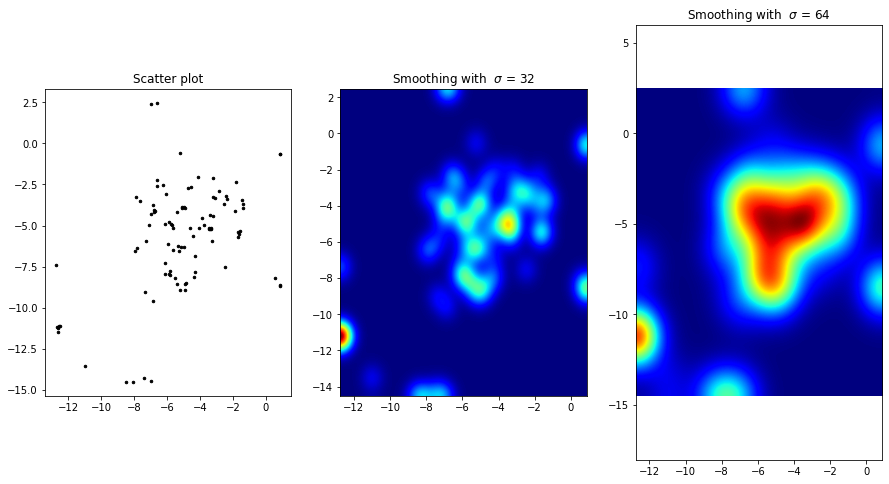

In [24]:
plot.bivariate_hist(xout)

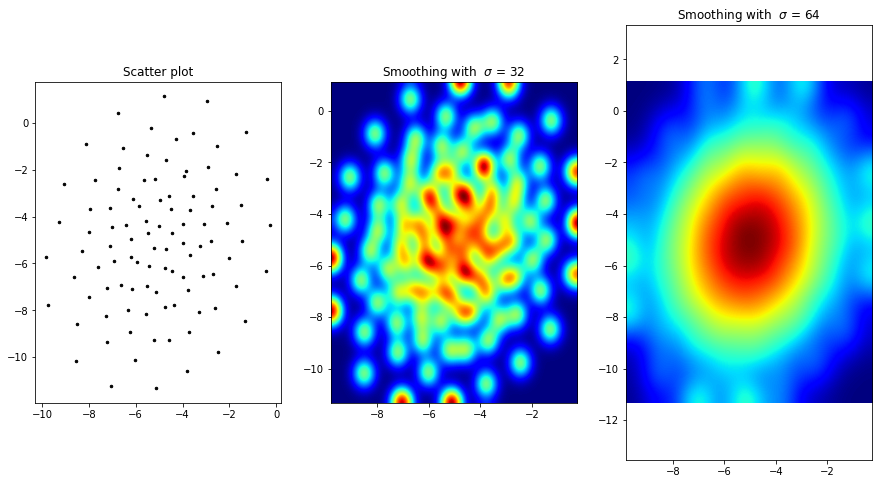

In [25]:
plot.bivariate_hist(xest)